In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
import hashlib
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn import datasets
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.multiclass import OneVsRestClassifier

In [2]:
df = pd.read_csv('C:/users/hoang/Desktop/Study/CAP4770/Project/USVideos/USVideos.csv'
#                  names = ['video_id', 'trending_date', 'title', 'channel_title','category_id','publish_time',
# 'tags',
# 'views',
# 'likes',
# 'dislikes',
# 'comment_count',
# 'thumbnail_link',
# 'comments_disabled',
# 'ratings_disabled',
# 'video_error_or_removed',
# 'description']
                )

In [3]:
data = df[(df['title'] != '[none]' ) & (df['tags'] != '[none]' ) \
          & (df['views'] != '[none]' )& (df['likes'] != '[none]' ) \
          &(df['dislikes'] != '[none]' ) \
          &(df['comment_count'] != '[none]' )]

C:\Users\hoang\Anaconda3\lib\site-packages\pandas\core\ops\__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39414 entries, 0 to 40948
Data columns (total 16 columns):
video_id                  39414 non-null object
trending_date             39414 non-null object
title                     39414 non-null object
channel_title             39414 non-null object
category_id               39414 non-null int64
publish_time              39414 non-null object
tags                      39414 non-null object
views                     39414 non-null int64
likes                     39414 non-null int64
dislikes                  39414 non-null int64
comment_count             39414 non-null int64
thumbnail_link            39414 non-null object
comments_disabled         39414 non-null bool
ratings_disabled          39414 non-null bool
video_error_or_removed    39414 non-null bool
description               39119 non-null object
dtypes: bool(3), int64(5), object(8)
memory usage: 4.3+ MB


In [5]:
preprocessed_data = data.drop(['description', 'thumbnail_link', 'comments_disabled', 'ratings_disabled', 'video_error_or_removed', 'publish_time', 'channel_title', 'trending_date', 'video_id', 'tags', 'title'], axis=1)
preprocessed_data.head()
text_data = data.drop(['views', 'likes', 'dislikes', 'comment_count', 'thumbnail_link', 'comments_disabled', 'ratings_disabled', 'video_error_or_removed','video_id', 'publish_time'], axis=1)

In [6]:
X = preprocessed_data.drop('category_id', axis=1)
y = preprocessed_data['category_id']

In [7]:
from nltk.stem import PorterStemmer 
from nltk.tokenize import word_tokenize 
   
ps = PorterStemmer() 
def getWords(col:str, data_notNull):
    common_words = set(stopwords.words('english'))
    tagsArray = text_data[col]
    tag2D = []
    tagsArray
    
    for (i,tag) in enumerate(tagsArray):
        lineArray = tag.split('|')
        words = []
        for sentence in lineArray:
            words = words + re.split(r'\W+', sentence.strip())
           
        tag2D.append(words)
        
    for i in range(len(tag2D)):
        temp = [u for u in tag2D[i] if u.lower() not in common_words] 
        temp = " ".join(ps.stem(str(x)) for x in temp)
        tag2D[i] = temp
                
    return tag2D

In [8]:
arr2d_words = getWords('title',text_data)
orr2d_words = getWords('tags', text_data)

In [9]:
X['modified_title'] = arr2d_words
X['modified_tags'] = orr2d_words

In [10]:
le = LabelEncoder()
le.fit(X['modified_title'])
X['labeled_title'] = le.transform(X['modified_title'])
oc = LabelEncoder()
oc.fit(X['modified_tags'])
X['labeled_tags'] = oc.transform(X['modified_tags'])

In [11]:
X = X.drop('modified_title', axis=1)
X = X.drop('modified_tags', axis=1)

In [12]:
import time

In [13]:
X

,views,likes,dislikes,comment_count,labeled_title,labeled_tags
0,748374,57527,2966,15954,5934,4865
1,2418783,97185,6146,12703,5751,3154
2,3191434,146033,5339,8181,4551,4460
3,343168,10172,666,2146,4143,4605
4,2095731,132235,1989,17518,1554,4691
...,...,...,...,...,...,...
40943,8259128,645888,4052,62610,1044,942
40944,1685609,38160,1385,2657,1194,179
40946,1066451,48068,1032,3992,2337,2158
40947,5660813,192957,2846,13088,910,737


In [14]:
def roc_scores(y_test, y_score, n_classes):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    return fpr, tpr, roc_auc

def histogram_feature(feature):
    fig, ax = plt.subplots()
    plt.hist(data[feature])
    plt.xlabel(feature)
    plt.ylabel('No. of Videos')

def histogram_log_feature(feature):
    fig, ax = plt.subplots()
    plt.hist(data[feature], log=True)
    plt.xlabel(feature)
    plt.ylabel('Log(No. of Videos)')

def bivariate_scatterplot(feature1, feature2):
    fig, ax = plt.subplots()
    plt.scatter(x=data[feature1], y=data[feature2], edgecolor="#000000", linewidths=0.5)
    ax.set(xlabel=feature1, ylabel=feature2)

def kdeplot(feature, data):
    sns.kdeplot(data[feature], shade=true)

def countplot(feature, data):
    sns.countplot(x=feature, data=data, linewidth=5)

#generates an ROC curve for one feature
#args are false positive and true positve rate array for one class
#and the roc_auc for that class
def single_attribute_roc_curve(fpr_arr, tpr_arr, roc_auc_arr):
    
    plt.figure()
    lw = 2
    plt.plot(fpr_arr, tpr_arr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_arr)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    


def full_attr_roc_curve(fpr, tpr, roc_auc, y_test, y_score, n_classes):
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    #grabs all unique false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    #interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    lw = 2
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'tan', 'rosybrown', 'lightcoral', 'maroon', 'peru',
                   'darkorange', 'gold', 'darkkhaki', 'lawngreen', 'turquoise', 'lightcyan', 'steelblue',
                    'slategray','indigo', 'violet', 'salmon', 'dodgerblue', 'darkgoldenrod' , 'burlywood', 'lime',
                   'yellow', 'bisque', 'forestgreen', 'aquamarine', 'indianred', 'mediumorchid', 'cadetblue', 'sandybrown',
                   'peachpuff'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi class ROC curve')
    plt.legend(loc="lower right")
    
    plt.show()

In [15]:
import json

with open("./US_category_id.json") as f:
    categories = json.load(f)['items']
    
categories

category_list = []
category_map = {}
for cat in categories:
    category_id = int(cat['id'])
    category_map[category_id] = cat['snippet']['title']

for cat in categories:
    category_id = int(cat['id'])
    category_list.append(category_id)

# y = label_binarize(y, classes=y.unique().tolist())
# n_classes = y.shape[1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Ox_train, Ox_test, Oy_train, Oy_test = train_test_split(X,y, test_size=0.35)

text_features_train = X_train.drop(['views', 'likes', 'dislikes', 'comment_count'], axis=1)
text_features_test = X_test.drop(['views', 'likes', 'dislikes', 'comment_count'], axis=1)
X_train = X_train.drop(['labeled_title', 'labeled_tags'], axis=1)
X_test = X_test.drop(['labeled_title', 'labeled_tags'], axis=1)

In [16]:
X_train = X_train.reset_index().drop('index', axis=1)
X_test = X_test.reset_index().drop('index', axis=1)

In [17]:
quantile_scaler = QuantileTransformer(output_distribution='uniform').fit(X_train)
quantile_transformer = QuantileTransformer(output_distribution='uniform').fit(X_train)
Xq_train = quantile_scaler.transform(X_train)
Xq_test = quantile_scaler.transform(X_test)

In [18]:
Xq_train = quantile_scaler.transform(X_train)
Xq_test = quantile_scaler.transform(X_test)

In [19]:
payload = text_features_train.reset_index().drop('index',axis=1).join(pd.DataFrame(Xq_train, columns=['views','likes','dislikes','comment_count']))
payload_test = text_features_test.reset_index().drop('index',axis=1).join(pd.DataFrame(Xq_test, columns=['views','likes','dislikes','comment_count']))

In [20]:
from sklearn.ensemble import RandomForestClassifier
start_time = time.time()
model = RandomForestClassifier(n_estimators = 100).fit(payload, y_train)
print(time.time() - start_time)

6.01129674911499


In [21]:
predict = model.predict(payload_test)

In [22]:
print (accuracy_score(y_test, predict))
from sklearn.metrics import recall_score
recall_score(y_test, predict, average='macro')

0.9317518711150578


0.8942108700343232

In [25]:
the_list = y.unique().tolist()
len(the_list)
y_pred_labels = []
y_test_labels = []
for pred in predict:
    l = [0] * 16
    l[the_list.index(pred)] = 1
    y_pred_labels.append(l)
    
for test in y_test:
    l = [0] * 16
    l[the_list.index(test)] = 1
    y_test_labels.append(l)

y_pred_labels = np.array(y_pred_labels)
y_test_labels = np.array(y_test_labels)
fpr_rf, tpr_rf, roc_auc_rf = roc_scores(y_test_labels, y_pred_labels,len(y_pred_labels[0]))

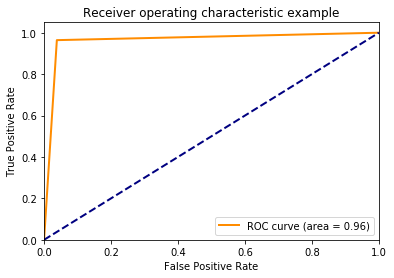

In [26]:
single_attribute_roc_curve(fpr_rf[1], tpr_rf[1], roc_auc_rf[1])